In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras as keras
from keras import layers as layers
import numpy as np

In [3]:
import os
import cv2
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from math import inf as inf
import numpy as np

In [4]:
from spectral.io import envi as envi
from spectral import imshow

In [5]:
from sklearn.decomposition import IncrementalPCA

In [6]:
import keras_tuner as kt

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
from sys import platform
DATA_DIRECTORY = ""

if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "\mnt\\"
elif platform == "win32":
    DATA_DIRECTORY = "D:\mvl\wheat\data\BULK\\"

In [9]:
#Testing Constants
TESTING = False

#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.85
IMAGE_COUNT = 5
NUM_VARIETIES = 2
NUM_OF_BANDS = 12
FIRST_BAND = 21
LAST_BAND = 149

IMAGE_WIDTH = 40
IMAGE_HEIGHT = 40

NUM_EPOCHS = 5
ACTIVATION_TYPE =  ["relu", "tanh","sigmoid"]
BATCH_SIZE = 2*NUM_VARIETIES

LEARNING_RATE_BASE = 0.0001
MIN_LEARNING_RATE_BASE = LEARNING_RATE_BASE/10

In [10]:
def exactPathHDR(variety,file):
    return DATA_DIRECTORY+variety+"\\"+file+".bil.hdr"

def exactPathBIL(variety,file):
    return DATA_DIRECTORY+variety+"\\"+file+".bil"

In [11]:
def getROI(img,band_number):
    img_band = img.read_band(band_number)
    threshold = threshold_otsu(img_band)
    roi=[]
    for x in range(img_band.shape[0]):
        a=[]
        for y in range(img_band.shape[1]):
            if img_band[x][y]>threshold:
                a.append(1)
            else:
                a.append(0)
        roi.append(a)
    return roi

In [12]:
#Returns range for x and y from where we have to crop images
def getRangeXandY(img,band_number):
    img_band = img.read_band(band_number)
    roi = getROI(img,band_number)
    xmin = inf
    xmax = 0
    ymin = inf
    ymax = 0
    for x in range(img_band.shape[0]):
        for y in range(img_band.shape[1]):
            if roi[x][y]==1:
                if x<xmin:
                    xmin=x
                if x>xmax:
                    xmax=x
                if y<ymin:
                    ymin=y
                if y>ymax:
                    ymax=y
    return xmin, xmax, ymin, ymax

In [13]:
def getCroppedImage(img,band_number):
    xmin, xmax, ymin, ymax = getRangeXandY(img,band_number)
    new_img = img[xmin:xmax, ymin:ymax, :]
    return new_img    

In [14]:
def getCroppedROI(img,band_number):
    xmin, xmax, ymin, ymax = getRangeXandY(img,band_number)
    roi = np.array(getROI(img,band_number))
    roi = roi[xmin:xmax, ymin:ymax]
    return roi   

In [15]:
def getUsefulImage(img,band_number):
    crop_img = getCroppedImage(img,band_number)
    crop_roi = getCroppedROI(img,band_number)
    for x in range(crop_img.shape[2]):
        band = crop_img[:,:,x]
        crop_img[:,:,x] = band*crop_roi
    return crop_img

In [16]:
data_augmentation = keras.Sequential([
    layers.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    layers.RandomRotation(factor=(-0.1, 0.1)),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1,0.1)),
    layers.RandomFlip(mode="horizontal_and_vertical", seed=None)
])

def getAugumentedImage(img,band_number):
    new_img = getUsefulImage(img,band_number)
    augmented_image = data_augmentation(new_img) 
    return augmented_image

def checkAugumentedImage(augmented_image):
    aug_band = augmented_image[:,:,0]
    filled_area_ratio = (np.count_nonzero(aug_band))/(aug_band.shape[0]*aug_band.shape[1])
    if filled_area_ratio > FILLED_AREA_RATIO :
        return True
    else:
        return False

In [17]:
## Dimensional Reduction Method
def DL_Method(HSI, numComponents = NUM_OF_BANDS):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    n_batches = 10
    inc_pca = IncrementalPCA(n_components=numComponents)
    for X_batch in np.array_split(RHSI, n_batches):
        inc_pca.partial_fit(X_batch)
    X_ipca = inc_pca.transform(RHSI)
    RHSI = np.reshape(X_ipca, (HSI.shape[0],HSI.shape[1], numComponents))
    return RHSI

In [18]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [19]:
#List for all file names in varities
FILES = []
MAX_FILE_NUM = 4
for x in range(1,MAX_FILE_NUM+1):
    FILES.append("B_"+str(x))

In [20]:
#List of all images
images = []
images_label = []
for v in VARIETIES:
    for f in FILES:
        try:
            img = envi.open(exactPathHDR(v,f),exactPathBIL(v,f))
            images.append(img)
            images_label.append(v)
        except:
            pass

In [21]:
train_dataset = []
train_dataset_label = []
test_dataset = []
test_dataset_label = []

for index, img in enumerate(images):
    count = 0
    label = images_label[index]
    while count<IMAGE_COUNT:
        aug_img = getAugumentedImage(img,BAND_NUMBER)
        
        if checkAugumentedImage(aug_img):
            aug_img = DL_Method(aug_img[:,:,FIRST_BAND:LAST_BAND+1])
            if count%5 == 0:
                test_dataset.append(aug_img)
                test_dataset_label.append(label)
            else:
                train_dataset.append(aug_img)
                train_dataset_label.append(label)
            count+=1  
            
    if TESTING:
        break

In [25]:
images_label

['DBW 187',
 'DBW 187',
 'DBW 187',
 'DBW 187',
 'DBW222',
 'DBW222',
 'DBW222',
 'DBW222']

In [26]:
images

[	Data Source:   'D:\mvl\wheat\data\BULK\DBW 187\B_1.bil'
 	# Rows:            850
 	# Samples:         320
 	# Bands:           168
 	Interleave:        BIL
 	Quantization:  32 bits
 	Data format:   float32,
 	Data Source:   'D:\mvl\wheat\data\BULK\DBW 187\B_2.bil'
 	# Rows:            850
 	# Samples:         320
 	# Bands:           168
 	Interleave:        BIL
 	Quantization:  32 bits
 	Data format:   float32,
 	Data Source:   'D:\mvl\wheat\data\BULK\DBW 187\B_3.bil'
 	# Rows:            850
 	# Samples:         320
 	# Bands:           168
 	Interleave:        BIL
 	Quantization:  32 bits
 	Data format:   float32,
 	Data Source:   'D:\mvl\wheat\data\BULK\DBW 187\B_4.bil'
 	# Rows:            343
 	# Samples:         320
 	# Bands:           168
 	Interleave:        BIL
 	Quantization:  32 bits
 	Data format:   float32,
 	Data Source:   'D:\mvl\wheat\data\BULK\DBW222\B_1.bil'
 	# Rows:            850
 	# Samples:         320
 	# Bands:           168
 	Interleave:        BIL
 	Quant

ImageView object:
  Display bands       :  [0, 84, 167]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.5394431948661804]
    G: [0.046013712882995605, 0.7377827167510986]
    B: [0.0, 0.4559013247489929]

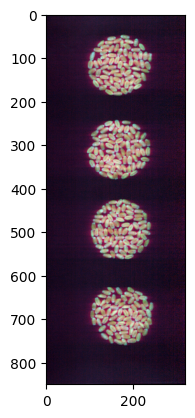

In [27]:
imshow(images[0])

ImageView object:
  Display bands       :  [0, 6.0, 11]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-3.490930737561067, 2.9994380851385585]
    G: [-0.023661931657118013, 0.03663881054231417]
    B: [-0.009312419931630837, 0.00699484895241529]

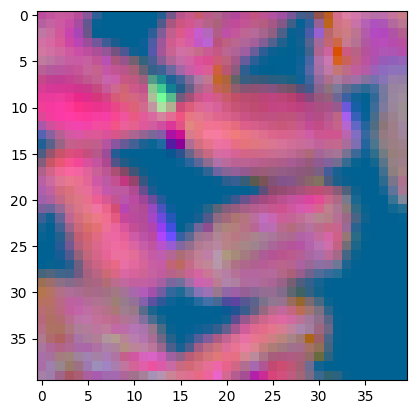

In [28]:
imshow(train_dataset[0])

In [22]:
train_dataset = np.array(train_dataset)
train_dataset_label = np.array(VARIETIES_CODE[label] for label in train_dataset_label)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(VARIETIES_CODE[label] for label in test_dataset_label)

In [23]:
for index,data in enumerate(test_dataset):
#     imshow(data)
    print(test_dataset_label[index])
    

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
for index,data in enumerate(train_dataset):
#     imshow(data)
    print(train_dataset_label[index])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
# import math, sys, pdb, os
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm
import cv2
from keras import activations
import vis
# from vis.visualization import visualize_saliency, overlay
# from vis.utils import utils

In [ ]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [ ]:
def make_hyperparam_string(learning_rate_base, batch_size, kernel_size, dropout_rate, num_training,
                           num_nodes_fc, activation_type):
    hparam = ""
    hparam += str(num_nodes_fc) + "nodes_" + str(learning_rate_base) + "lr_" + str(batch_size) + "batch_" + str(
        kernel_size) + "kernel_" + str(dropout_rate) + "drop_" + str(
        num_training) + "train_" + activation_type

    return hparam

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.clim(0,sum(cm[0,:]))
    plt.xlabel('Predicted label')

In [ ]:
def top_K_classification_accuracy(y_predicted, y_true, K=1):

    num_samples = y_predicted.shape[0]
    num_classes = y_predicted.shape[1]

    if K > num_classes:
        sys.exit(1)

    temp = np.zeros((num_samples,))

    for idx in range(num_samples):
        curr_predicted = np.argsort(y_predicted[idx,:])
        curr_predicted = curr_predicted[::-1] # descending

        if y_true[idx] in curr_predicted[:K]:
            temp[idx] = 1

    return 100.0 * np.sum(temp)/num_samples

In [ ]:
def conv2D_ResNet(x, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D):

    x_orig = x

    # Batch norm
    x = BatchNormalization()(x)

    # 1x1 Conv2D
    x = Conv2D(num_filters_first_conv1D, kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Activation
    x = Activation(activation_type)(x)

    x = BatchNormalization()(x)

    # 3x3 Conv2D
    x = Conv2D(num_filters_first_conv1D, kernel_size, activation=None, use_bias=True, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Activation       
    x = Activation(activation_type)(x)

    x = BatchNormalization()(x)

    # 1x1 Conv2D
    x = Conv2D(num_filters_first_conv1D*4, kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Skip connection
    if int(x.shape[3]) != int(x_orig.shape[3]):
        x_orig = Conv2D(int(x.shape[3]), kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x_orig)

    # Activation      
    x = Activation(activation_type)(x)

    x = Add()([x, x_orig])

    # Dropout
    return Dropout(dropout_rate)(x)

In [ ]:
def createBlock_ResNet2D(hp,index,x, num_layers, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D):

    for idx_layer in range(hp.Int('layers'+str(index),int(num_layers/4),num_layers)):
        x = conv2D_ResNet(x, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D)

    return x

In [ ]:
# growth_rate: number of filters for each normal convolution ('k' in the paper)
def ResNet2D_classifier(hp,data_num_rows, data_num_cols, num_classes, kernel_size=3, num_layers_each_block=[6, 12, 24, 16],
                        num_chan_per_block = [64,128,256,512], activation_type=['relu'], dropout_rate=0.0, num_input_chans=1, num_nodes_fc=64):

    input_data = Input(shape=(data_num_rows, data_num_cols, num_input_chans))

    # Input layer: Conv2D -> activation
    x = Conv2D(num_chan_per_block[0], kernel_size, activation=None, use_bias=True, padding='same',
               kernel_initializer='truncated_normal')(input_data)

    # Activation
    x = Activation(activation_type)(x)


    #  Blocks & Downsampling Layers
    for idx_block in range(len(num_layers_each_block)):
        x = createBlock_ResNet2D(hp,idx_block,x, num_layers_each_block[idx_block], kernel_size, activation_type, dropout_rate,
                                 num_chan_per_block[idx_block])

        x = BatchNormalization()(x)

        if idx_block != len(num_layers_each_block)-1:
            x = Conv2D(num_chan_per_block[idx_block]*2, kernel_size, strides = 2, activation=None, use_bias=True, padding='valid',
                   kernel_initializer='truncated_normal')(x)
        else:
            x = GlobalAveragePooling2D()(x)

        x = Dropout(dropout_rate)(x)

    # Output layer
    x = BatchNormalization()(x)
    x = Dense(units=num_nodes_fc, activation=None, kernel_initializer='truncated_normal')(x)

    # Activation
    x = Activation(activation_type)(x)

    x = BatchNormalization()(x)
    output_data = Dense(units=num_classes, activation='softmax', kernel_initializer='truncated_normal')(x)

    return Model(inputs=input_data, outputs=output_data)

In [ ]:
def evaluate(model,dataset,dataset_label,normalization_type):
    print("--------------Make Predictions--------------")    
    x = np.array(dataset)
    labels = np.array(dataset_label)
    
    # Normalize the data
    x = normalizeDataWholeSeed(x,normalization_type=normalization_type)
    
    num = x.shape[0]

    print("Testing started")
    tic = timeit.default_timer()
    labels_predicted = model.predict(x)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')
    
    print(labels_predicted)
    print("--------")
    # Classification accuracy
    labels_integer_format = labels
    labels_predicted_integer_format = np.argmax(labels_predicted, axis=1)

    acc_top2 = top_K_classification_accuracy(labels_predicted, labels_integer_format, K=2)
    acc_top1 = top_K_classification_accuracy(labels_predicted, labels_integer_format, K=1)
    
    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_integer_format, labels_predicted_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)
    print("------------------------------------------------")

In [ ]:
def predict(model,normalization_type):
    evaluate(model,train_dataset,train_dataset_label,normalization_type)
    
    evaluate(model,test_dataset,test_dataset_label,normalization_type)
    
    
    # Precision, Recall, F1
#     macro_avg = np.asarray(
#         precision_recall_fscore_support(labels_test_integer_format, labels_predicted_test_integer_format,
#                                         average='macro'))
#     macro_avg_precision = macro_avg[0]
#     macro_avg_recall = macro_avg[1]
#     macro_avg_fscore = macro_avg[2]

#     print('Top-1 accuracy (%) = ' + str(acc_top1) + '\n')
#     print('Top-2 accuracy (%) = ' + str(acc_top2) + '\n')
#     print('Macro-avg precision = ' + str(macro_avg_precision) + '\n')
#     print('Macro-avg recall = ' + str(macro_avg_recall) + '\n')
#     print('Macro-avg f-score = ' + str(macro_avg_fscore) + '\n')

#     print("--------------Done--------------")

#     print("--------------Compute Saliency Maps--------------")
#     results_test_dir = os.path.join(results_dir, 'test')
#     if not os.path.exists(results_test_dir):
#         os.makedirs(results_test_dir)

#     # Swap softmax with linear
#     model.layers[-1].activation = activations.linear
#     model = utils.apply_modifications(model)

#     for idx_wheat in range(num_test):

#         grads = visualize_saliency(model, layer_idx=-1, filter_indices=np.argmax(labels_test[idx_wheat, :], axis=0),
#                                    seed_input=x_test[idx_wheat], backprop_modifier=None)

#         ss_img = np.sqrt(np.sum(abs(x_test[idx_wheat, :, :, :]) ** 2, axis=2))
#         ss_img /= np.max(ss_img)

#         plt.figure(1)
#         plt.subplot(3, 1, 1)
#         plt.imshow(ss_img, cmap='gray')
#         plt.clim(0, 1)
#         plt.axis('off')
#         plt.colorbar()

#         plt.subplot(3, 1, 2)
#         plt.imshow((grads * np.uint8(255)).astype('uint8'), cmap='jet')
#         plt.clim(0, 255)
#         plt.axis('off')
#         plt.colorbar()

#         jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * np.uint8(255))

#         plt.subplot(3, 1, 3)
#         ss_img = cv2.cvtColor((ss_img * np.uint8(255)).astype('uint8'), cv2.COLOR_GRAY2RGB)
#         plt.imshow(overlay(jet_heatmap, ss_img, alpha=0.3))
#         plt.clim(0, 255)
#         plt.axis('off')
#         plt.colorbar()

#         plt.savefig(os.path.join(results_test_dir, str(idx_wheat+1) + '.png'))
#         plt.clf()

#     print("--------------Done--------------")

#     print("--------------Save the information--------------")

#     # Write some information to files
#     f = open(os.path.join(results_test_dir, 'testing_info.txt'), 'w')
#     f.write("Wheat types = " + str(wheat_types) + "\n")
#     f.write("Confusion matrix \n")
#     f.write(str(confusion_matrix_results) + "\n")
#     f.write("Normalization type = " + str(normalization_type) + "\n")
#     f.write("# test samples = %d \n" % (num_test))
#     f.write("Top-1 test accuracy = %f \n" % (acc_top1))
#     f.write("Top-2 test accuracy = %f \n" % (acc_top2))
#     f.write("Macro-avg precision = %f \n" % (macro_avg_precision))
#     f.write("Macro-avg recall = %f \n" % (macro_avg_recall))
#     f.write("Macro-avg f-score = %f \n" % (macro_avg_fscore))
#     f.write("Test time (s) = " + str(test_time) + "\n")
#     f.close()

#     # Save confusion matrices
#     plt.figure(1)
#     plot_confusion_matrix(confusion_matrix_results, classes=wheat_types, normalize=False, title='Confusion matrix')
#     plt.savefig(os.path.join(results_test_dir,'confusionMatrix.png'))
#     plt.clf()

#     print("--------------Done--------------")

#     print("--------------Save the information for the training phase--------------")
    
#     import pandas as pd
    
#     # Save the trained model
#     model.save_weights(os.path.join(results_dir, 'trainedResNetB_weights.h5'))
    
#     # Extract the training loss   
#     training_loss = hist.history['loss']

#     # Save the training loss
#     df = pd.DataFrame(data={'training loss': training_loss},index=np.arange(num_epochs)+1)
#     df.to_csv(os.path.join(results_dir,'training_loss.csv'))
    
#     # Save the training loss as a figure
#     plt.figure(1)
#     plt.title('Loss')
#     plt.plot(training_loss, color='b',label='Training')
#     plt.legend()
#     plt.grid()
#     plt.savefig(os.path.join(results_dir,'training_loss.png'))
#     plt.clf()   
    
#     # Write a file with general information
#     f = open(os.path.join(results_dir,'training_info.txt'),'w')
#     f.write(hparams + '\n')
#     f.write('Wheat types = ' + str(wheat_types)+'\n')
#     f.write('Training time (s) = %f \n' %(training_time))
#     f.write('Normalization type = ' + str(normalization_type)+ '\n')
#     f.write('# epochs = ' + str(num_epochs) + '\n')
#     f.write('# training samples = %d \n' %(num_training))
#     f.close()
    
#     print("--------------Done--------------")

In [ ]:
def createAndTrainResNetB(hp):
    
    learning_rate_base = LEARNING_RATE_BASE
    kernel_size = 3
    num_epochs = NUM_EPOCHS
    batch_size = BATCH_SIZE
    dropout_rate = 0.15 
    activation_type = hp.Choice('act',ACTIVATION_TYPE)
    num_nodes_fc = 512
    wheat_types =  VARIETIES
    normalization_type = 'max'
    num_layers_each_block = [8, 8, 12, 8]
    num_chan_per_block = [128, 128, 256, 256]
    N_classes = len(wheat_types)
    
    ############ Load data ############
    print("--------------Load Data--------------")

    # Load training data and their corresponding labels
    x_training = np.array(train_dataset)
    labels_training = np.array(train_dataset_label)
    print(train_dataset_label)
    print(labels_training)
    
    # Normalize the data
    x_training = normalizeDataWholeSeed(x_training,normalization_type=normalization_type)
    
    # Extract some information
    num_training = x_training.shape[0]
    N_spatial = x_training.shape[1:3]
    N_bands = x_training.shape[3]
    num_batch_per_epoch = int(num_training/batch_size)
    
    print('#training = %d' %(num_training))
    print('#batches per epoch = %d' %(num_batch_per_epoch))
    
    print("--------------Done--------------")
    
    
    ############ Prepare the path for saving the models/stats ############
    print("--------------Prepare a path for saving the models/stats--------------")
    
    hparams = make_hyperparam_string(learning_rate_base, batch_size, kernel_size, dropout_rate,
                                     num_training, num_nodes_fc, activation_type)
    print('Saving the model to...')
    
    results_dir = os.path.join('./results/',hparams)
    
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    print(results_dir)

    print("--------------Done--------------")

    ############ Create a model ############
    print("--------------Create a model--------------")
    
    # Generate a model
    model = ResNet2D_classifier(hp=hp,data_num_rows=N_spatial[0], data_num_cols=N_spatial[1], num_classes=N_classes,
                                kernel_size=kernel_size, num_layers_each_block=num_layers_each_block,
                                num_chan_per_block=num_chan_per_block, activation_type=activation_type,
                                dropout_rate=dropout_rate, num_input_chans=N_bands, num_nodes_fc=num_nodes_fc)

    # Compile the model
    adam_opt = Adam(learning_rate=hp.Float("lr", min_value=MIN_LEARNING_RATE_BASE, max_value=learning_rate_base, sampling="log"), beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

    # Create a Tensorboard callback
    tbCallBack = TensorBoard(log_dir=results_dir, histogram_freq=0, write_graph=False, write_images=False)
    
    print("--------------Done--------------")

    ############ Train the model ############
    print("--------------Begin training the model--------------")

    tic = timeit.default_timer()
    
    # Train the model
    hist = model.fit(x=x_training,y=labels_training,batch_size=batch_size, steps_per_epoch=num_batch_per_epoch, epochs = num_epochs, initial_epoch = 0, verbose=2, callbacks = [tbCallBack],validation_split=0.15,shuffle=True)

    toc = timeit.default_timer()
    training_time = toc-tic
    print("Total training time = " + str(training_time))
    
    print("--------------Done--------------")

    return model

In [ ]:
hp = kt.HyperParameters()

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=createAndTrainResNetB,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_dataset,train_dataset_label , epochs=2, validation_split=0.15)

In [ ]:
tuner.results_summary()